# Evolution des températures


Le dataset que l'on va utiliser:

[Daily Temperature of Major Cities](https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities?select=city_temperature.csv)

## Questions:

Global:
 - Quelle est la moyenne des températures par continent et par an ? 
On gardera seulement les villes qui ont plus de 80% de valeurs renseignées sur la période
 - Pour quelle ville et quelle année observe t'on l'écart de témpérature le plus grand ?
 
Focus sur une ville: Bordeaux
- Quelle est l'évolution de la température sur la période observée à Bordeaux ? 
- Observez-vous une tendance, une saisonnalité ? 
 
 
## Théorique: 
- Qu'est-ce qu'un modèle ARIMA ? 

Mise en pratique
- Modéliser la température à Bordeaux par un modèle ARIMA 
- Faites des prédictions sur l'année 2019 à partir de l'historique
- Comparer avec la vraie distribution

<H1>Importation des modules et du dataset

In [361]:
import pandas as pd
import math
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import pacf
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
register_matplotlib_converters()
pd.options.display.max_rows = 10

In [362]:
df = pd.read_csv("city_temperature.csv")

In [363]:
df

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
2906322,North America,US,Additional Territories,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,Additional Territories,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,Additional Territories,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,Additional Territories,San Juan Puerto Rico,7,30,2013,83.8


<H1>Nettoyage des données

<H2>Suppressions des duplicats et des valeurs manquantes

In [364]:
df = df.drop_duplicates(subset=['State','City', 'Month', 'Day', 'Year'],keep=False)

In [365]:
df.isna().sum()

Region                  0
Country                 0
State             1446515
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

Text(0.5, 1.0, 'Distribution de la Température moyenne en Fahrenheit')

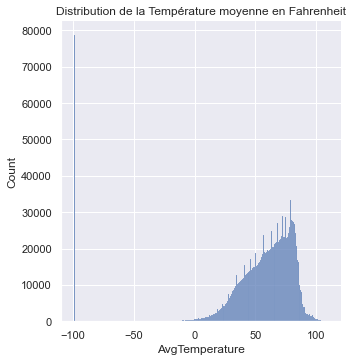

In [366]:
sns.displot(data = df,x = 'AvgTemperature')
plt.title("Distribution de la Température moyenne en Fahrenheit")

<b>Dans ce dataset les valeurs manquantes pour la colonne AvgTemperature on été remplacer par la valeur -99.

In [367]:
df.drop(df[df['AvgTemperature']==-99.0].index,inplace=True)

Text(0.5, 1.0, 'Distribution de la Température moyenne en Fahrenheit')

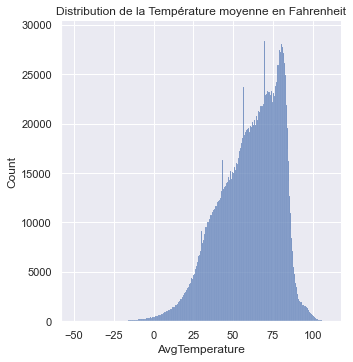

In [368]:
sns.displot(data = df,x = 'AvgTemperature')
plt.title("Distribution de la Température moyenne en Fahrenheit")

In [369]:
df['AvgTemperature_in_Celsius'] = (df['AvgTemperature'] - 32)/1.8 

In [370]:
df.AvgTemperature_in_Celsius.min(),df.AvgTemperature_in_Celsius.max(),df.AvgTemperature_in_Celsius.mean(),df.AvgTemperature_in_Celsius.median()

(-45.55555555555556,
 43.333333333333336,
 15.784265432870187,
 17.388888888888886)

<b>Notre jeu de données nettoyée présente une gamme de température allant de -45,5°C à 43,3°C avec une moyenne de 15,8°C et une mediane de 17,5°C.
Ces valeurs sont cohérentes.

<H2>Création de la colonne Date

In [371]:
df["Date"] = pd.to_datetime((df.Year*10000 + df.Month*100 + df.Day),format='%Y%m%d')

<H2>Supression des villes ayant moins de 80% de valeurs renseignées sur la période

In [372]:
df.sort_values(['Date'])

,Region,Country,State,City,Month,Day,Year,AvgTemperature,AvgTemperature_in_Celsius,Date
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2,17.888889,1995-01-01
785219,Europe,Ireland,NaN,Dublin,1,1,1995,34.3,1.277778,1995-01-01
468974,Asia,Pakistan,NaN,Karachi,1,1,1995,66.4,19.111111,1995-01-01
1961491,North America,US,Kentucky,Louisville,1,1,1995,42.6,5.888889,1995-01-01
586313,Australia/South Pacific,Australia,NaN,Melbourne,1,1,1995,73.1,22.833333,1995-01-01
...,...,...,...,...,...,...,...,...,...,...
1415563,South/Central America & Carribean,Panama,NaN,Panama City,5,13,2020,82.4,28.000000,2020-05-13
23074,Africa,Benin,NaN,Cotonou,5,13,2020,83.5,28.611111,2020-05-13
2658649,North America,US,Texas,Austin,5,13,2020,67.1,19.500000,2020-05-13
506036,Asia,South Korea,NaN,Seoul,5,13,2020,66.2,19.000000,2020-05-13


<b>Les données s'étendent du 1 janvier 1995 au 13 mai 2020.

In [373]:
delta = df.Date.max() - df.Date.min()
days_in_period = delta.days
days_in_period

9264

<b>Il y a 9264 enregistrements possibles au maximum par ville.

In [374]:
df_city_count = df.groupby(["City"]).count()

In [375]:
df_city_count

,Region,Country,State,Month,Day,Year,AvgTemperature,AvgTemperature_in_Celsius,Date
City,,,,,,,,,
Abidjan,9001,9001,0,9001,9001,9001,9001,9001,9001
Abilene,9237,9237,9237,9237,9237,9237,9237,9237,9237
Abu Dhabi,9231,9231,0,9231,9231,9231,9231,9231,9231
Addis Ababa,7141,7141,0,7141,7141,7141,7141,7141,7141
Akron Canton,9249,9249,9249,9249,9249,9249,9249,9249,9249
...,...,...,...,...,...,...,...,...,...
Yerevan,3188,3188,0,3188,3188,3188,3188,3188,3188
Youngstown,9249,9249,9249,9249,9249,9249,9249,9249,9249
Yuma,4087,4087,4087,4087,4087,4087,4087,4087,4087


In [376]:
len(df_city_count)

319

In [377]:
for row in df_city_count.index:
    if df_city_count["AvgTemperature"][row] < 0.8*days_in_period:
        df.drop(df[df.City==row].index,inplace=True)

In [378]:
df_city_count = df.groupby(["City"]).count()
len(df_city_count)

278

<b>51 villes ayant moins de 80% de relevé de températures sur la période ont été supprimées.

<H1>Analyse exploratoire des données

<H2>Moyenne des températures par continent

In [379]:
df_region = df.groupby(["Region"]).mean().drop(["Month","Day","AvgTemperature","Year"],axis=1)
df_region

,AvgTemperature_in_Celsius
Region,
Africa,23.737904
Asia,19.614321
Australia/South Pacific,16.834668
Europe,10.810928
Middle East,23.050157
North America,13.501188
South/Central America & Carribean,22.337014


Text(0.5, 1.0, 'Moyenne des températures par Region')

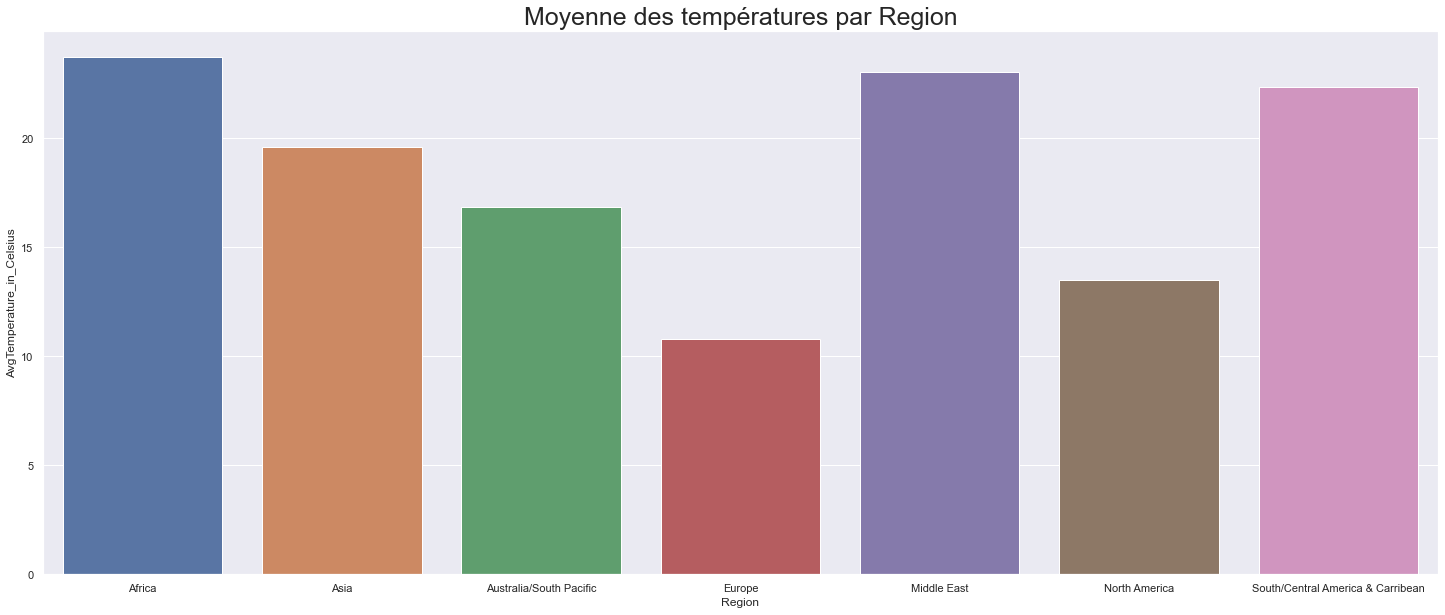

In [380]:
sns.barplot(data=df_region.reset_index(),x="Region",y="AvgTemperature_in_Celsius")
plt.title("Moyenne des températures par Region",size=25)

<H2>Moyenne des températures par an

In [381]:
df.groupby(["Year"]).mean().drop(["Month","Day","AvgTemperature"],axis=1)

,AvgTemperature_in_Celsius
Year,
1995,15.204342
1996,14.754650
1997,15.074300
1998,16.079717
1999,15.738404
...,...
2016,16.475523
2017,16.320108
2018,16.053043


Text(0.5, 1.0, 'Moyenne des températures par an')

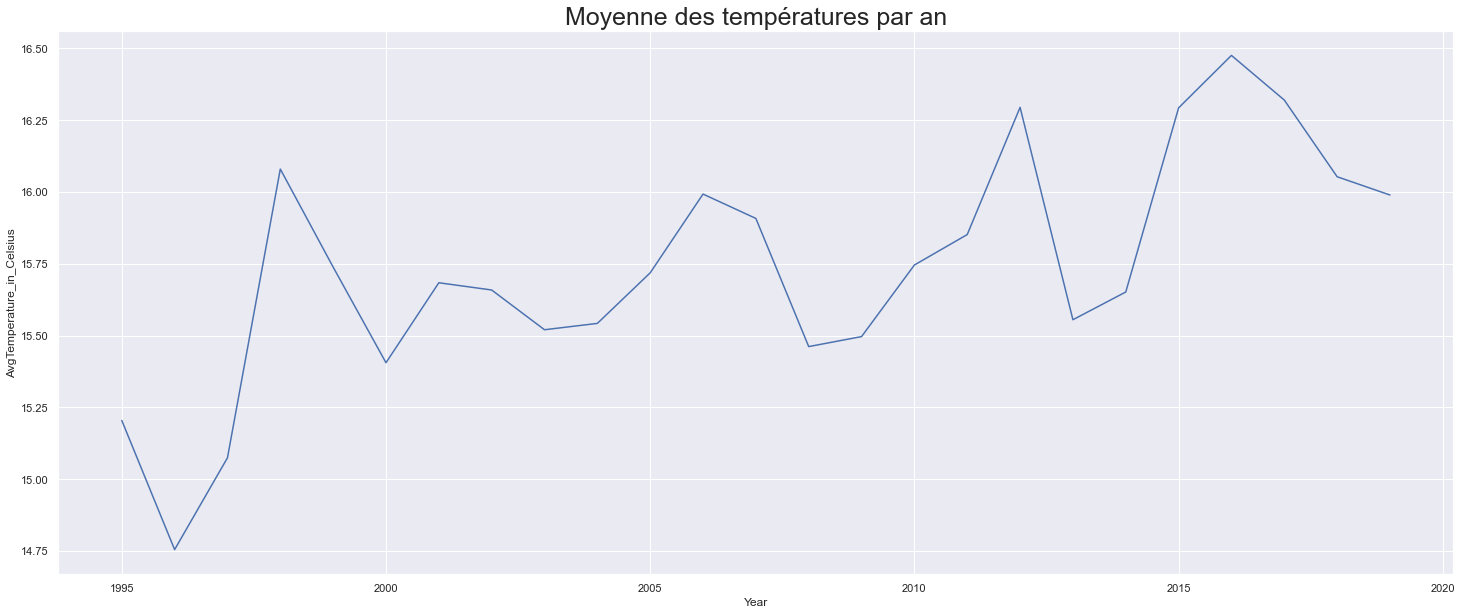

In [382]:
sns.lineplot(data=df.groupby(["Year"]).mean().reset_index()[df.groupby(["Year"]).mean().reset_index().Year != 2020],x="Year",y="AvgTemperature_in_Celsius")
plt.title("Moyenne des températures par an",size=25)

<H2>Moyenne des températures par continent et par an

In [383]:
pd.options.display.max_rows = 182
df_by_region_year = df.groupby(["Region","Year"]).mean()
df_by_region_year.drop(["Month","Day","AvgTemperature"],axis=1,inplace=True)

Text(0.5, 1.0, 'Moyenne des températures par continent et par an')

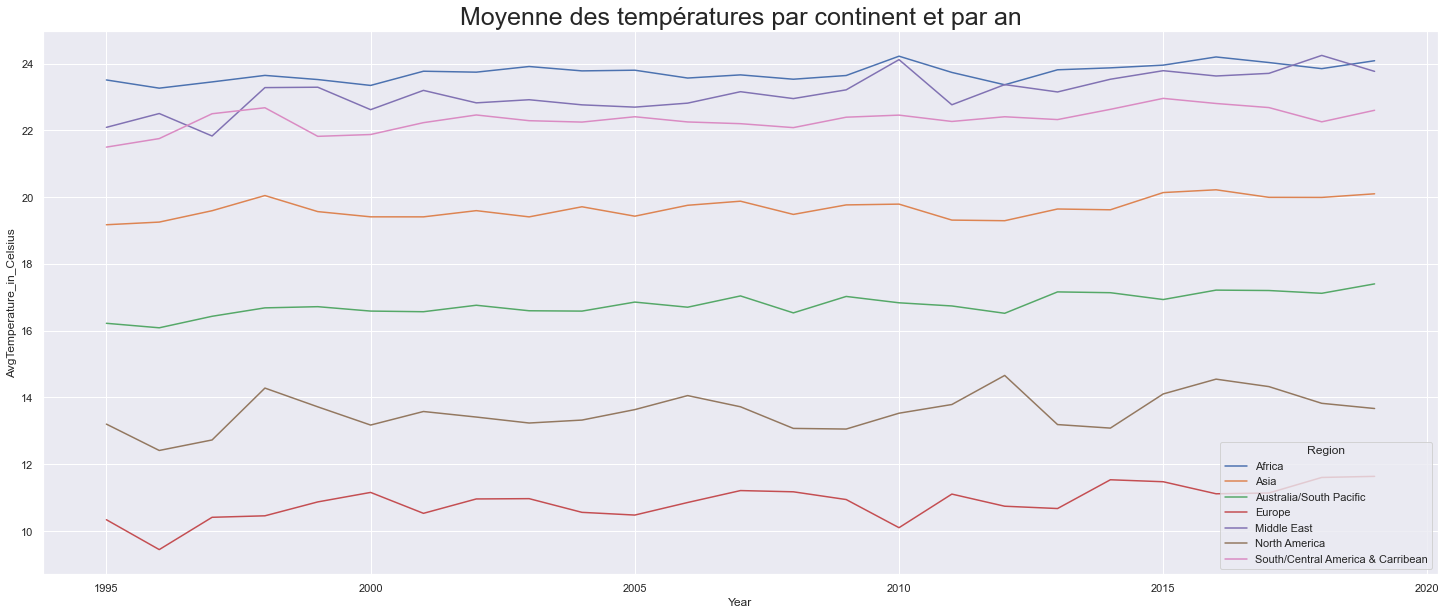

In [384]:
sns.lineplot(data=df_by_region_year.reset_index()[df_by_region_year.reset_index().Year != 2020],x="Year",y="AvgTemperature_in_Celsius",hue="Region")
plt.title("Moyenne des températures par continent et par an",size=25)

<H1>Pour quelle ville et quelle année observe t'on l'écart de témpérature le plus grand ?

In [385]:
df_city_temp_diff = df.groupby(["City","Year"]).min()
df_city_temp_diff.drop(['Region', 'Country', 'State', 'Month', 'Day', 'AvgTemperature_in_Celsius'],axis=1,inplace=True)
df_city_temp_diff.rename(columns={"AvgTemperature": "MinTemp"},inplace=True)
df_city_temp_diff["MaxTemp"] = df.groupby(["City","Year"]).max()["AvgTemperature"]
df_city_temp_diff["DiffTemp"] = df_city_temp_diff["MaxTemp"] - df_city_temp_diff["MinTemp"]
df_city_temp_diff["DiffTemp_in_Celsius"] = 1/1.8*df_city_temp_diff["DiffTemp"]

In [386]:
df_city_temp_diff

MinTemp       Date  MaxTemp  DiffTemp  DiffTemp_in_Celsius
City    Year                                                            
Abidjan 1995     73.0 1995-01-01     86.7      13.7             7.611111
        1996     72.2 1996-01-01     86.1      13.9             7.722222
        1997     73.0 1997-01-01     85.1      12.1             6.722222
        1998     73.4 1998-01-01     87.2      13.8             7.666667
        1999     73.4 1999-01-01     87.2      13.8             7.666667
...               ...        ...      ...       ...                  ...
Zurich  2016     20.0 2016-01-01     76.4      56.4            31.333333
        2017     17.4 2017-01-01     80.3      62.9            34.944444
        2018     14.5 2018-01-01     80.5      66.0            36.666667
        2019     26.1 2019-01-01     81.7      55.6            30.888889
        2020     27.0 2020-01-01     67.1      40.1            22.277778

[7210 rows x 5 columns]

In [387]:
df_city_temp_diff[df_city_temp_diff["DiffTemp"]==df_city_temp_diff["DiffTemp"].max()]

,,MinTemp,Date,MaxTemp,DiffTemp,DiffTemp_in_Celsius
City,Year,,,,,
Fairbanks,1999,-50.0,1999-01-01,74.2,124.2,69.0


<b>Le plus grand écart de température annuel à eu lieu à Fairbanks (Alaska) en 1999.

<H1>Focus sur la ville de Bordeaux

In [388]:
df_bordeaux = df[df.City=="Bordeaux"]

In [389]:
df_bordeaux

,Region,Country,State,City,Month,Day,Year,AvgTemperature,AvgTemperature_in_Celsius,Date
721686,Europe,France,NaN,Bordeaux,1,1,1995,42.0,5.555556,1995-01-01
721687,Europe,France,NaN,Bordeaux,1,2,1995,39.2,4.000000,1995-01-02
721688,Europe,France,NaN,Bordeaux,1,3,1995,31.4,-0.333333,1995-01-03
721689,Europe,France,NaN,Bordeaux,1,4,1995,30.5,-0.833333,1995-01-04
721690,Europe,France,NaN,Bordeaux,1,5,1995,32.3,0.166667,1995-01-05
...,...,...,...,...,...,...,...,...,...,...
730947,Europe,France,NaN,Bordeaux,5,9,2020,61.5,16.388889,2020-05-09
730948,Europe,France,NaN,Bordeaux,5,10,2020,56.4,13.555556,2020-05-10
730949,Europe,France,NaN,Bordeaux,5,11,2020,48.9,9.388889,2020-05-11
730950,Europe,France,NaN,Bordeaux,5,12,2020,50.2,10.111111,2020-05-12


In [390]:
df_bordeaux_2018 = df_bordeaux[df_bordeaux.Year==2018]

In [391]:
df_bordeaux_2018

,Region,Country,State,City,Month,Day,Year,AvgTemperature,AvgTemperature_in_Celsius,Date
730088,Europe,France,NaN,Bordeaux,1,1,2018,49.7,9.833333,2018-01-01
730089,Europe,France,NaN,Bordeaux,1,2,2018,53.6,12.000000,2018-01-02
730090,Europe,France,NaN,Bordeaux,1,3,2018,57.7,14.277778,2018-01-03
730092,Europe,France,NaN,Bordeaux,1,5,2018,51.9,11.055556,2018-01-05
730093,Europe,France,NaN,Bordeaux,1,6,2018,45.6,7.555556,2018-01-06
...,...,...,...,...,...,...,...,...,...,...
730448,Europe,France,NaN,Bordeaux,12,27,2018,48.2,9.000000,2018-12-27
730449,Europe,France,NaN,Bordeaux,12,28,2018,49.9,9.944444,2018-12-28
730450,Europe,France,NaN,Bordeaux,12,29,2018,33.4,0.777778,2018-12-29
730451,Europe,France,NaN,Bordeaux,12,30,2018,36.8,2.666667,2018-12-30


In [392]:
df_bordeaux_month = df[df.City=="Bordeaux"]

In [393]:
df_bordeaux_month = df_bordeaux_month.groupby(["Year","Month"]).mean().drop(["Day","AvgTemperature_in_Celsius"],axis=1)

In [394]:
df_bordeaux_month

AvgTemperature
Year Month                
1995 1           44.435484
     2           49.217857
     3           48.548387
     4           53.846667
     5           61.429032
...                    ...
2020 1           46.738710
     2           50.731034
     3           50.361290
     4           58.000000
     5           60.661538

[305 rows x 1 columns]

In [395]:
df_bordeaux.drop(["Region","Country","State","Month","Day","Year","City"],axis=1,inplace=True)

In [396]:
df_bordeaux

,AvgTemperature,AvgTemperature_in_Celsius,Date
721686,42.0,5.555556,1995-01-01
721687,39.2,4.000000,1995-01-02
721688,31.4,-0.333333,1995-01-03
721689,30.5,-0.833333,1995-01-04
721690,32.3,0.166667,1995-01-05
...,...,...,...
730947,61.5,16.388889,2020-05-09
730948,56.4,13.555556,2020-05-10
730949,48.9,9.388889,2020-05-11
730950,50.2,10.111111,2020-05-12


<H1>Evolution de la température sur la période observée à Bordeaux

In [397]:
sns.set_theme(style="darkgrid")

Text(0.5, 1.0, 'Evolution de la température sur la période observée à Bordeaux')

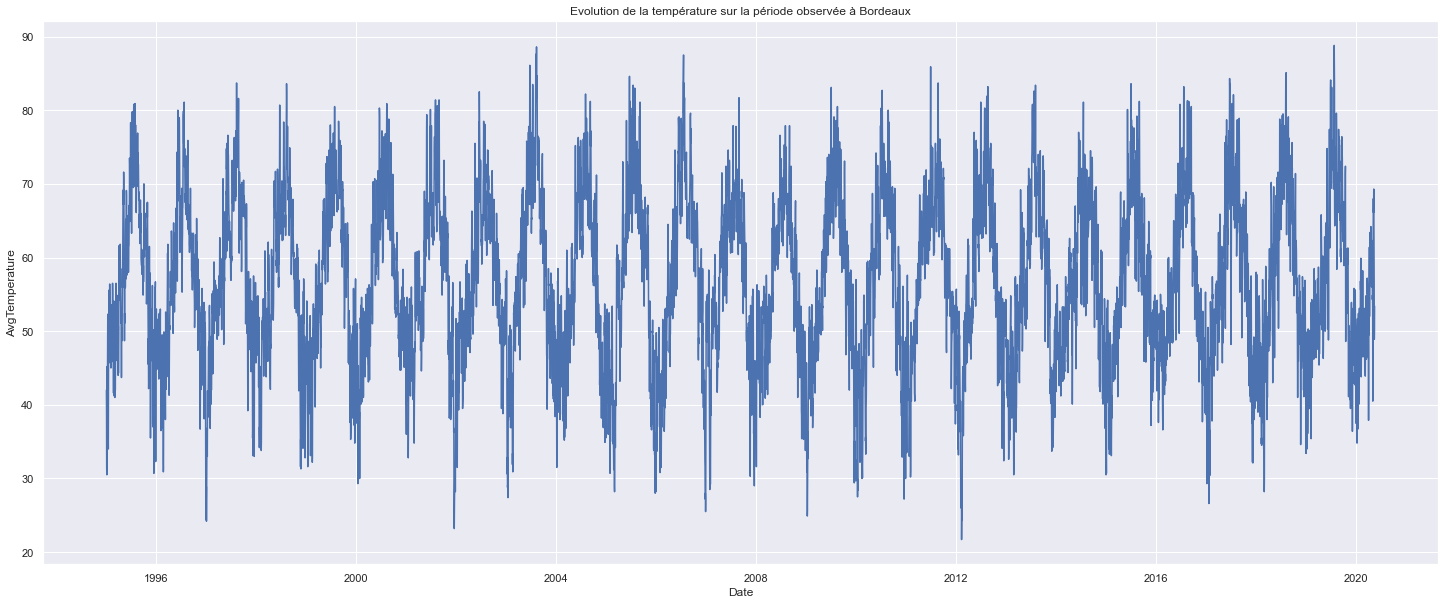

In [398]:
sns.set(rc = {'figure.figsize':(25,10)})
sns.lineplot(data=df_bordeaux,x="Date",y="AvgTemperature")
plt.title("Evolution de la température sur la période observée à Bordeaux")

In [399]:
df_bordeaux_day = pd.DataFrame({"Temperature":df_bordeaux.AvgTemperature})

In [400]:
df_bordeaux_day.index = pd.DatetimeIndex(data=df_bordeaux.Date)

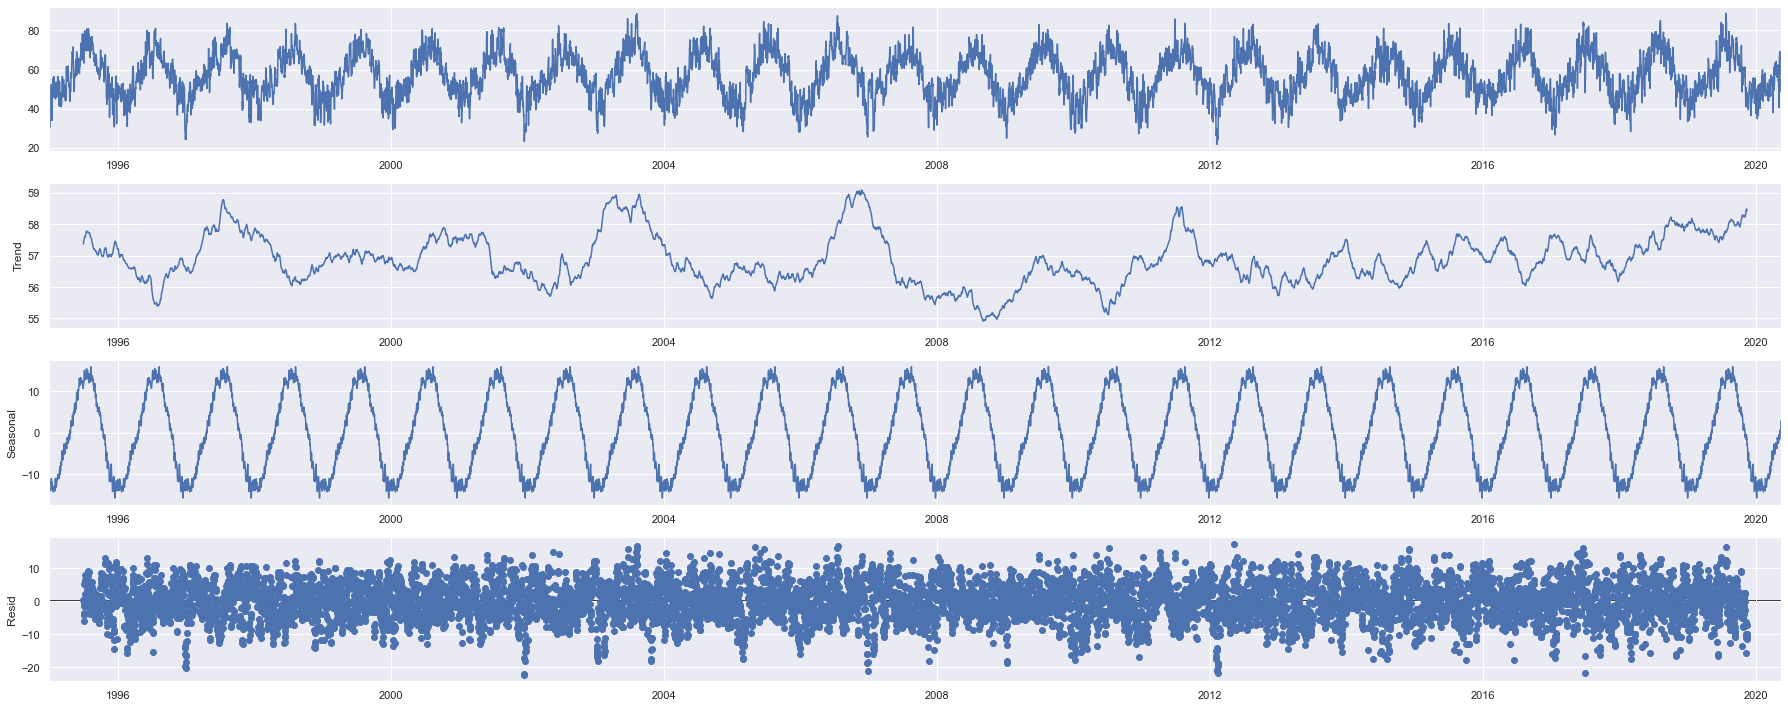

In [401]:
decomp_x = seasonal_decompose(x=df_bordeaux_day,model='additive',period=365)
decomp_x.plot()
plt.show()

<AxesSubplot:xlabel='Date'>

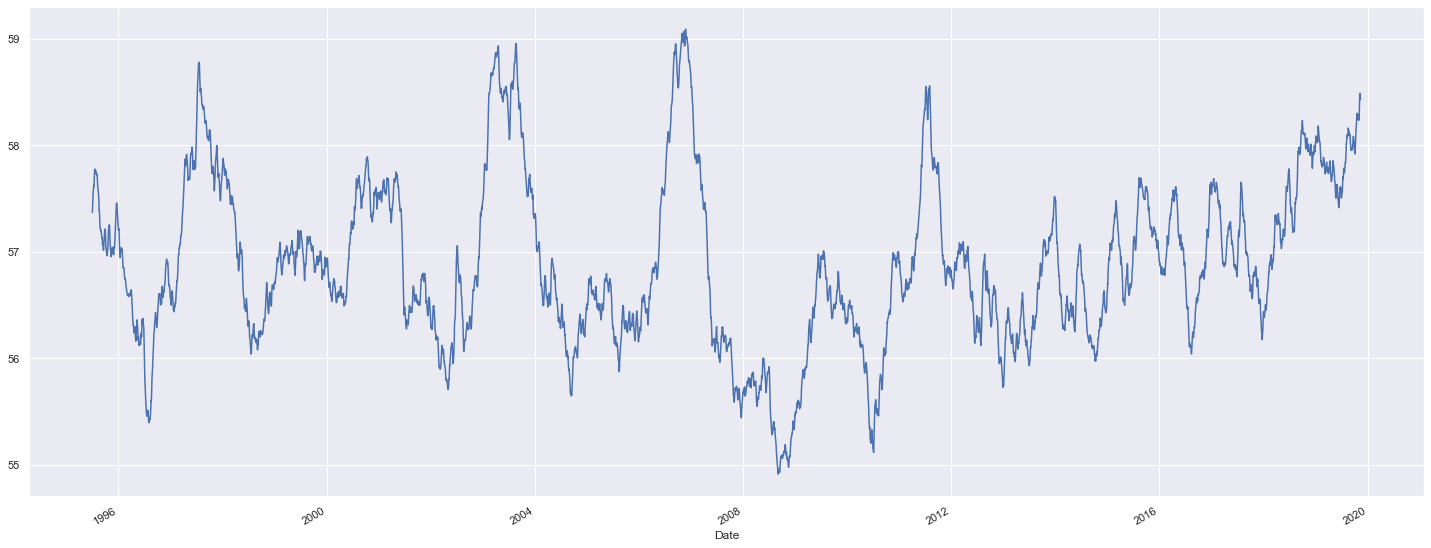

In [402]:
decomp_x.trend.plot()

<b>Pas de tendance particulière pour l'évolution des températures à Bordeaux sur la période. Pas d'évolution à la hausse ou à la baisse.

<AxesSubplot:xlabel='Date'>

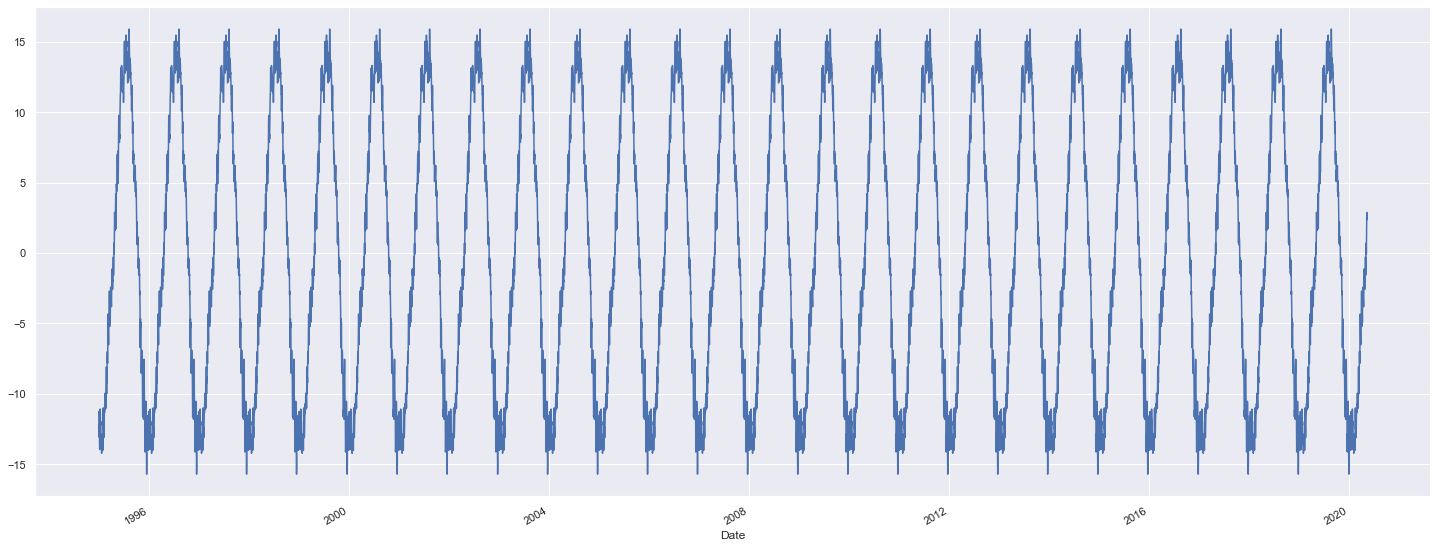

In [403]:
decomp_x.seasonal.plot()

<b>On observe un saisonnalité annuelle pour l'évolution des températures à Bordeaux

<H1>Qu'est-ce qu'un modèle ARIMA ?

<b>Le processus ARIMA est une association de différents de processus plus simples:

-le processus AR

-le processus MA

Le I du modèle ARIMA signifie ‘integrated’ pour intégration. En différenciant les séries temporelles, il est possible de retirer les tendances qu’elles présentent pour les stationnariser.

Par ailleurs, si la série temporelle présente à la fois une tendance et une saisonnalité, il est possible d’utiliser le modèle SARIMA qui est un modèle ARIMA prenant aussi en compte une composante saisonnière.

In [404]:
import statsmodels.api as sm

<b>La prédictions des températures sur Bordeaux via un modele ARIMA sera faite à partir des moyennes de températures mensuelles pour limiter le temps de calcul.

In [405]:
df_bordeaux_month["Date"] = None
for row in df_bordeaux_month.index:
    df_bordeaux_month["Date"][row] = date(row[0], row[1],1)

In [406]:
df_bordeaux_month.index = pd.DatetimeIndex(data=df_bordeaux_month.Date)
df_bordeaux_month.drop("Date",axis=1,inplace=True)

In [407]:
df_bordeaux_month

,AvgTemperature
Date,
1995-01-01,44.435484
1995-02-01,49.217857
1995-03-01,48.548387
1995-04-01,53.846667
1995-05-01,61.429032
...,...
2020-01-01,46.738710
2020-02-01,50.731034
2020-03-01,50.361290


In [408]:
stepwise_fit = auto_arima(df_bordeaux_month,trace=True,suppress_warnings=True, stepwise=False, maxiter=100, m=12, random_state=0)
stepwise_fit.summary()

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2266.889, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=2039.397, Time=0.32 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1942.631, Time=1.04 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1560.056, Time=3.10 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=4.36 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.62 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2016.814, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1891.718, Time=0.63 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=1842.792, Time=1.63 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1693.667, Time=2.31 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1566.136, Time=5.07 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=1584.195, Time=11.85 sec
 ARIMA(0,0,1)(2,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                  305
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                -776.028
Date:                    Mon, 09 May 2022   AIC                           1560.056
Time:                            14:22:52   BIC                           1574.937
Sample:                                 0   HQIC                          1566.008
                                    - 305                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3088      0.193      1.599      0.110      -0.070       0.687
ar.S.L12       0.9944      0.003    290.274      0.000       0.988       1.001
ma.S.L12      -0.7473      0.061    -12.187      0.000      -0.867      -0.627
sigma2         8.5654      0.853     10.039      0.000       6.893      10.238
===================================================================================
Ljung-Box (L1) (Q):                   9.51   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.00   Prob(JB):                         0.64
Heteroskedasticity (H):               1.08   Skew:                            -0.03
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<b>Meilleur modele : ARIMA(1,0,1)(1,0,2)[12]

In [409]:
df_bordeaux_month_1995_2018 = df_bordeaux_month.iloc[:288]

In [410]:
model=sm.tsa.statespace.SARIMAX(df_bordeaux_month_1995_2018,order=(1, 0, 1),seasonal_order=(1,0,2,12))

In [411]:
model = model.fit()

In [429]:
pred=model.predict(start=1,end=len(df_bordeaux_month_1995_2018)+12)
print(pred)

1995-02-01    40.360239
1995-03-01    44.576241
1995-04-01    45.857041
1995-05-01    47.807362
1995-06-01    50.483321
                ...    
2019-09-01    65.092464
2019-10-01    58.622496
2019-11-01    50.425077
2019-12-01    45.221592
2020-01-01    44.587671
Freq: MS, Name: predicted_mean, Length: 300, dtype: float64


In [430]:
df_bordeaux_month_1995_2018["Predictions"] = pred.values[:288]

In [431]:
df_bordeaux_month_1995_2018


,AvgTemperature,Predictions
Date,,
1995-01-01,44.435484,40.360239
1995-02-01,49.217857,44.576241
1995-03-01,48.548387,45.857041
1995-04-01,53.846667,47.807362
1995-05-01,61.429032,50.483321
...,...,...
2018-08-01,72.754839,65.363164
2018-09-01,67.313333,58.445911
2018-10-01,57.822581,50.746783


In [432]:
df_bordeaux_month_2019 = df_bordeaux_month.iloc[288:300]
df_bordeaux_month_2019["Predictions"] = pred.values[288:300]

In [433]:
df_bordeaux_month_2019

,AvgTemperature,Predictions
Date,,
2019-01-01,42.720000,45.149290
2019-02-01,49.182143,50.601146
2019-03-01,52.109677,55.243438
2019-04-01,54.431034,60.968194
2019-05-01,57.979310,67.365169
2019-06-01,66.773333,70.306101
2019-07-01,74.416129,70.097981
2019-08-01,71.158065,65.092464
2019-09-01,66.716667,58.622496


Text(0.5, 1.0, "Predictions des températures sur Bordeaux pour la période 1995-2018 (Données d'entrainement")

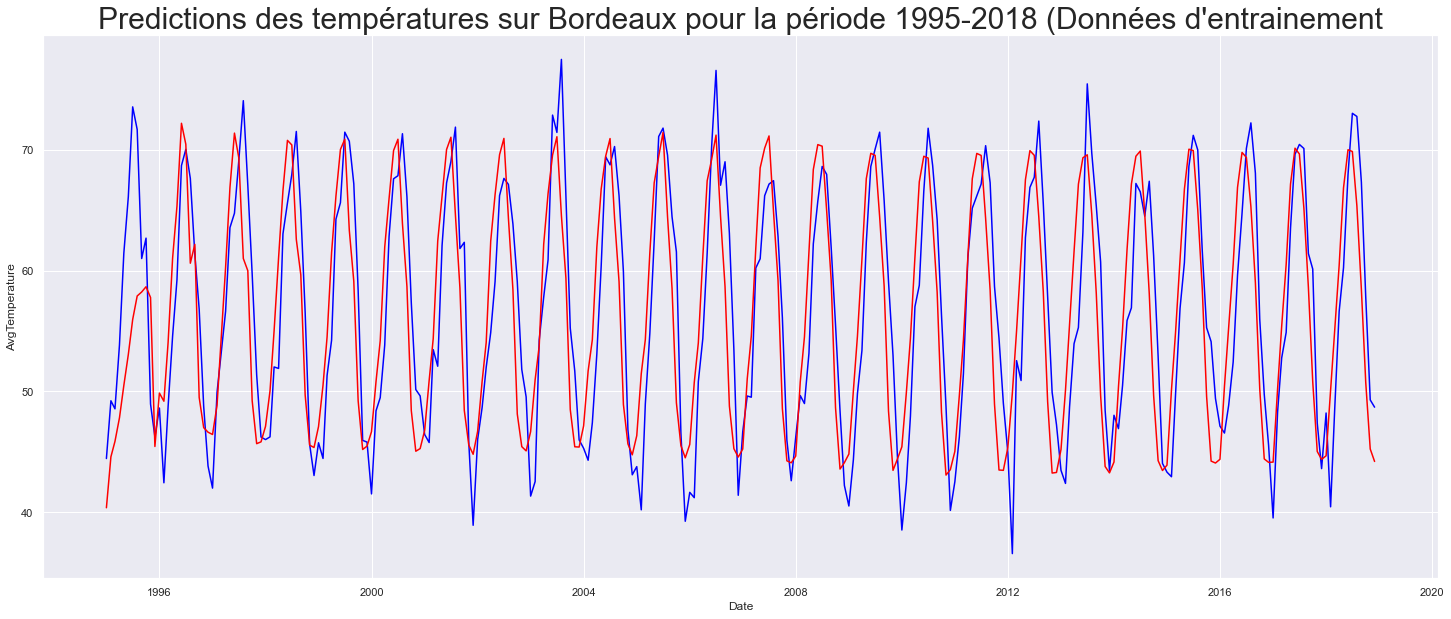

In [434]:
sns.lineplot(x=df_bordeaux_month_1995_2018.index,y=df_bordeaux_month_1995_2018.AvgTemperature,color="blue")
sns.lineplot(x=df_bordeaux_month_1995_2018.index,y=df_bordeaux_month_1995_2018.Predictions,color="red")
plt.title("Predictions des températures sur Bordeaux pour la période 1995-2018 (Données d'entrainement",size=30)

Text(0.5, 1.0, "Predictions des températures sur Bordeaux pour l'année 2019")

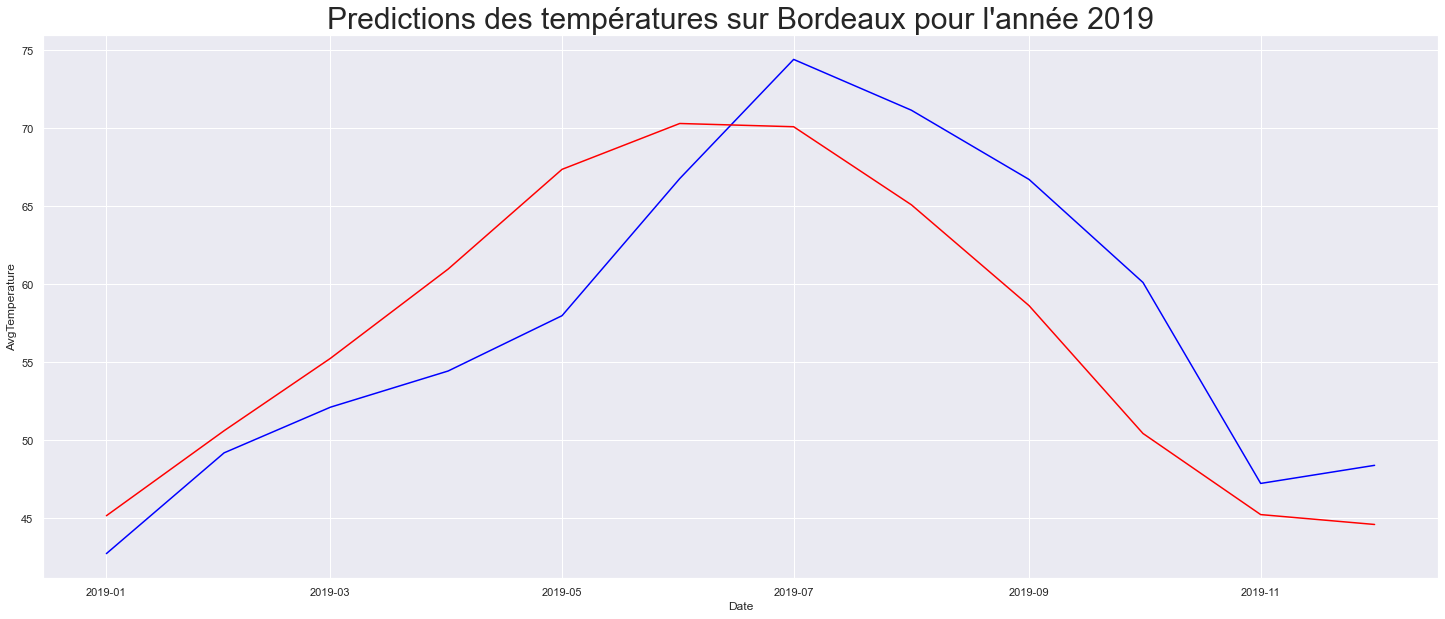

In [435]:
sns.lineplot(x=df_bordeaux_month_2019.index,y=df_bordeaux_month_2019.AvgTemperature,color="blue")
sns.lineplot(x=df_bordeaux_month_2019.index,y=df_bordeaux_month_2019.Predictions,color="red")
plt.title("Predictions des températures sur Bordeaux pour l'année 2019",size=30)

<b>Il me semble que je n'ai pas assez de puissance de calcul pour entrainer un modele SARIMAX() avec les donneés journalières

Avis ?